Code to read survey results

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

In [2]:
import pandas as pd
import numpy as np
import openpyxl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [3]:
def read_ods(filename):
    # Use pandas to read the ODS file. The `engine='odf'` parameter is necessary to read ODS files.
    # Adjust the `sheet_name` parameter as needed. By default, it reads the first sheet.
    df = pd.read_excel(filename, engine='odf')
    return df

# Define a function to replace "not numbered" with the value in "Variable Label"
def replace_not_numbered(row):
    if row["Question number\n (Questionnaire file)"] == "not numbered":
        return row["Variable Label\n (Data files)"]
    else:
        return row["Question number\n (Questionnaire file)"]

# Replace 'example.ods' with the path to your ODS file
filename = 'dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_map.ods'

# Read the ODS file
metaInfo = read_ods(filename)

# Initialize empty lists to store grouped response options
question_numbers = []
variable_labels = []
descriptions = []
response_options = []

# Loop through DataFrame rows
current_question = None
for index, row in metaInfo.iterrows():
    if not pd.isnull(row['Question number(Questionnaire file)']):
        # If it's a new question, store its details
        current_question = row['Question number(Questionnaire file)']
        question_numbers.append(row['Question number(Questionnaire file)'])
        variable_labels.append(row['Variable Label(Data files)'])
        descriptions.append(row['Description'])
        response_options.append([(row['Values'], row['Value labels'])])
    elif current_question is not None:
        # If it's a response option, add it to the previous question's response options
        response_options[-1].append((row['Values'], row['Value labels']))

# Create a new DataFrame with grouped response options
grouped_df = pd.DataFrame({
    'Question number(Questionnaire file)': question_numbers,
    'Variable Label(Data files)': variable_labels,
    'Description': descriptions,
    'Response Options': response_options
})

grouped_df

,Question number(Questionnaire file),Variable Label(Data files),Description,Response Options
0,ID,ID,Respondent ID to match respondents between waves,"[(nan, nan)]"
1,not numbered,Q0_age,Age,"[(1.0, 16-24), (2.0, 25-34), (3.0, 35-44), (4...."
2,not numbered,Q0_gender,What gender do you identify with?,"[(1.0, Male), (2.0, Female)]"
3,not numbered,Q0_race_US,What race do you self-identify as? (USA only),"[(1.0, White), (2.0, Black or African American..."
4,not numbered,Q0_ethnicity_ID,What ethnic group do you identify as? (Indones...,"[(1.0, Jawa), (2.0, Sunda), (3.0, Madura), (4...."
...,...,...,...,...
214,Q60,Q60_elder,Yes – adults over 70,"[(0.0, No), (1.0, Yes)]"
215,Q60,Q60_no,No,"[(0.0, No), (1.0, Yes)]"
216,Q60,Q60_not_say,Prefer not to say,"[(0.0, No), (1.0, Yes)]"
217,Q60a,Q60a_parent,Are you the parent or guardian of any children...,"[(0.0, No), (1.0, Yes)]"


In [4]:
#Wave 1
NLDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_NL.csv").set_index("ID")
CNDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_CN.csv").set_index("ID")
IDDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_ID.csv").set_index("ID")
USDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Wave_1_US.csv").set_index("ID")

#Wave 2
NLDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_NL.csv").set_index("ID")
CNDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_CN.csv").set_index("ID")
IDDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_ID.csv").set_index("ID")
USDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Wave_2_US.csv").set_index("ID")

#Wave 2 Recontact
NLDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_NL.csv").set_index("ID")
CNDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_CN.csv").set_index("ID")
IDDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_ID.csv").set_index("ID")
USDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_US.csv").set_index("ID")

#Wave 3
NLDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_NL.csv").set_index("ID")
CNDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_CN.csv").set_index("ID")
IDDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_ID.csv").set_index("ID")
USDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Wave_3_US.csv").set_index("ID")

#Wave 4
NLDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_NL.csv").set_index("ID")
CNDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_CN.csv").set_index("ID")
IDDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_ID.csv").set_index("ID")
USDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_US.csv").set_index("ID")

#All waves
AllWave1 = pd.concat([NLDataWave1, CNDataWave1, IDDataWave1, USDataWave1])
AllWave2 = pd.concat([NLDataWave2, CNDataWave2, IDDataWave2, USDataWave2])
AllWave2rec = pd.concat([NLDataWave2rec, CNDataWave2rec, IDDataWave2rec, USDataWave2rec])
AllWave3 = pd.concat([NLDataWave3, CNDataWave3, IDDataWave3, USDataWave3])
AllWave4 = pd.concat([NLDataWave4, CNDataWave4, IDDataWave4, USDataWave4])

#All Data
AllData = pd.concat([AllWave1, AllWave2, AllWave2rec, AllWave3,AllWave4], axis=1,)

In [5]:
survey_questions  = pd.read_excel('Survey Questions Overview.xlsx', sheet_name='Wave 1', engine='openpyxl')
# Clean the survey questions dataframe to make it more usable for mapping
# Fill forward non-null ADICO Category values to apply them to all relevant rows, Specify the columns to forward fill excluding "Values" and "Value labels"
columns_to_ffill = [col for col in survey_questions.columns if col not in ["Values", "Value labels"]]

# Forward fill the specified columns
survey_questions[columns_to_ffill] = survey_questions[columns_to_ffill].ffill()


# Apply the function to replace "not numbered" with the value in "Variable Label"
survey_questions["Question number\n (Questionnaire file)"] = survey_questions.apply(replace_not_numbered, axis=1)


# Set the index to {value of "Question number\n (Questionnaire file)"} + "_" + {str(value of "Values")}
survey_questions.set_index(survey_questions["Variable Label\n (Data files)"] + "_" + survey_questions["Values"].astype(str), inplace=True)
survey_questions.drop("ID_nan", inplace=True)
survey_questions.drop_duplicates(inplace=True)

question_answers_list = []
# Define a function to create the combined string
def combine_description_and_labels(group, question_answers_list):
    question_subset = survey_questions[survey_questions["Question number\n (Questionnaire file)"] == group["Question number\n (Questionnaire file)"].iloc[0]]
    # Check if it's the first row instance with the current "Question number\n (Questionnaire file)" column value
    first_instance_index = question_subset[question_subset.duplicated(subset=["Question number\n (Questionnaire file)"], keep="first")].index
    first_description = ""
    combined_string = ""
    if first_instance_index.size != 0:
        first_description = question_subset["Description"].iloc[0]
        for i in group.index:  
            if first_description != group["Description"].loc[i]:
                # If not the first instance, start with the first instance's "Description" column value
                combined_string = first_description
            # Concatenate the current row's "Description" and all "Value labels" values
            combined_string += str(group["Description"].loc[i] + " Response: " + str(group["Value labels"].loc[i]))
            question_answers_list = question_answers_list + [combined_string]  # Extend the list with the combined strings
    
    else:question_answers_list = question_answers_list + [""]  # Extend the list with the no answer

    return question_answers_list

# Group by "Variable Label\n (Data files)" and apply the function to create the combined string
for group in survey_questions.groupby("Variable Label\n (Data files)",sort=False):
    question_answers_list = combine_description_and_labels(group[1], question_answers_list)
survey_questions["question_answers_combined"] = question_answers_list


# Since the dataset has multiple rows per question for different value labels, we'll create a unique mapping
# Create the new mapping dictionary
question_adico_mapping = survey_questions[['question_answers_combined','ADICO Category',"Variable Label\n (Data files)"]].drop_duplicates().set_index('question_answers_combined')

# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = list(set([Attribute for Attribute in question_adico_mapping[question_adico_mapping['ADICO Category'].isin(["Attribute", "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Conditions = list(set([Condition for Condition in question_adico_mapping[question_adico_mapping['ADICO Category'].isin(["Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Aims = list(set([Aim for Aim in question_adico_mapping[question_adico_mapping['ADICO Category'].isin(["Aim", "Aim/Condition"])]['Variable Label\n (Data files)']]))
Attcons = list(set([Attcon for Attcon in question_adico_mapping[question_adico_mapping['ADICO Category'].isin(["Attribute", "Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

In [6]:
aim_responses = NLDataWave1.copy()
chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]
for aim in aim_responses.columns:
    if aim == "R06a_media_freq":
        aim_responses.loc[aim_responses[aim] > 3, aim] = 5
        aim_responses.loc[aim_responses[aim] <= 3, aim] = 1
    elif "implementation" in aim:
        aim_responses.loc[aim_responses[aim] > 5, aim] = 6
        aim_responses.loc[aim_responses[aim] <= 5, aim] = 1


In [7]:
# Filter columns that exist in NLDataWave1 for Aims and Attcons
valid_aims = [aim for aim in Aims if aim in aim_responses.columns]
valid_attcons = [attcon for attcon in Attcons if attcon in aim_responses.columns]

# Initialize a list to hold data before creating DataFrame
data_list = []

# Iterate over valid aims
for aim in chosen_aims:
    # Group by Aim
    aim_groups = aim_responses.groupby(aim)

    for aim_value, aim_group in aim_groups:
        for attcon in valid_attcons:
            # Ensure the Condition is not the same as Aim
            if attcon == aim:
                continue
            # print(aim_group[attcon].unique())
            # Group by Condition within Aim group
            condition_groups = aim_group.groupby(attcon)
            
            for condition_value, group in condition_groups:
                # Calculate the count
                count = len(group)
                # Apply your condition for count
                if count > 15:
                    data_list.append([attcon, condition_value, aim, aim_value, count])

# Create DataFrame from the list in a single operation
shared_strategies_noatt = pd.DataFrame(data_list, columns=["Condition", "Condition_value", "Aim", "Aim_value", "Count"])

# Reset index if needed
shared_strategies_noatt.reset_index(inplace=True, drop=True)

In [8]:
shared_strategies_noatt

,Condition,Condition_value,Aim,Aim_value,Count
0,Q17_compens_other,0.0,R06a_media_freq,1,17
1,Q60_not_say,0.0,R06a_media_freq,1,17
2,Q17_compens_noone,0.0,R06a_media_freq,1,17
3,Q48_business_owner,0.0,R06a_media_freq,1,16
4,R2_implementation_SM2,6.0,R06a_media_freq,1,16
5,Q60_child,0.0,R06a_media_freq,1,16
6,Q60_elder,0.0,R06a_media_freq,1,16
7,Q18_flood_exp,0.0,R06a_media_freq,1,17
8,Q17_compens_other,0.0,R2_implementation_SM3,6,18
9,Q61_single_parent,0.0,R2_implementation_SM3,6,16


In [9]:
# Initialize new columns to store text descriptions
shared_strategies_noatt["Condition_text"] = ""
shared_strategies_noatt["Aim_text"] = ""

# Iterate over each row in the DataFrame
for i in shared_strategies_noatt.index:
    # Extract the index of the row in survey_questions matching the condition
    ConditionRow = survey_questions[survey_questions["Variable Label\n (Data files)"] == shared_strategies_noatt.at[i,"Condition"]]
    ConditionRow = ConditionRow[ConditionRow["Values"] == shared_strategies_noatt.at[i,"Condition_value"]].index[0]
    
    # Assign the corresponding text description to the "Condition_text" column
    shared_strategies_noatt.at[i, "Condition_text"] = str(survey_questions.at[ConditionRow, "question_answers_combined"])

    # Extract the index of the row in survey_questions matching the aim
    AimRow = survey_questions[survey_questions["Variable Label\n (Data files)"] == shared_strategies_noatt.at[i,"Aim"]]
    AimRow = AimRow[AimRow["Values"] == shared_strategies_noatt.at[i,"Aim_value"]].index[0]
    
    # Assign the corresponding text description to the "Aim_text" column
    shared_strategies_noatt.at[i, "Aim_text"] = str(survey_questions.at[AimRow, "question_answers_combined"])

# Save the DataFrame to a CSV file
shared_strategies_noatt.to_csv("shared_strategies_noatt.csv", index=False)


In [10]:
survey_questions

,ADICO Category,Question number\n (Questionnaire file),Variable Label\n (Data files),Description,Values,Value labels,question_answers_combined
Q0_age_1.0,Attribute,Q0_age,Q0_age,Age,1.0,16-24,Age Response: 16-24
Q0_age_2.0,Attribute,Q0_age,Q0_age,Age,2.0,25-34,Age Response: 16-24Age Response: 25-34
Q0_age_3.0,Attribute,Q0_age,Q0_age,Age,3.0,35-44,Age Response: 16-24Age Response: 25-34Age Resp...
Q0_age_4.0,Attribute,Q0_age,Q0_age,Age,4.0,45-54,Age Response: 16-24Age Response: 25-34Age Resp...
Q0_age_5.0,Attribute,Q0_age,Q0_age,Age,5.0,55-64,Age Response: 16-24Age Response: 25-34Age Resp...
...,...,...,...,...,...,...,...
Q60a_parent_0.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,0.0,No,Are you the parent or guardian of any children...
Q60a_parent_1.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,1.0,Yes,Are you the parent or guardian of any children...
Q61_single_parent_0.0,Condition,Q61,Q61_single_parent,Are you a single parent?,0.0,No,Are you a single parent? Response: No
Q61_single_parent_1.0,Condition,Q61,Q61_single_parent,Are you a single parent?,1.0,Yes,Are you a single parent? Response: NoAre you a...


R06a_media_freq


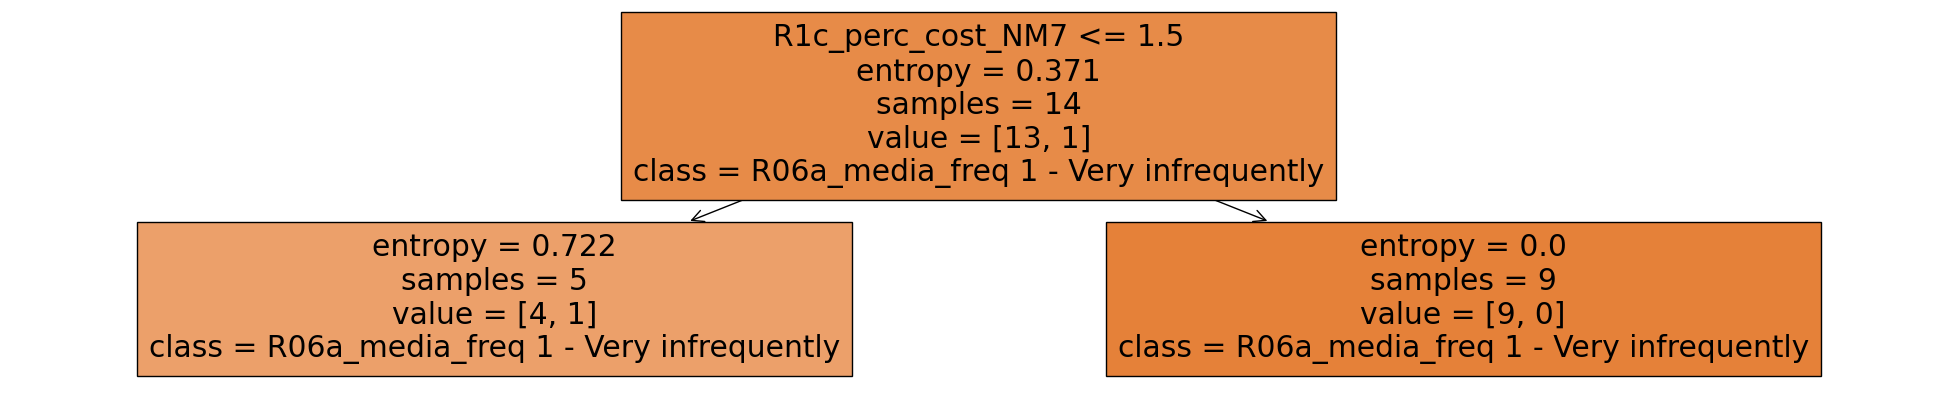

Accuracy is 0.6666666666666666
R2_implementation_NM4


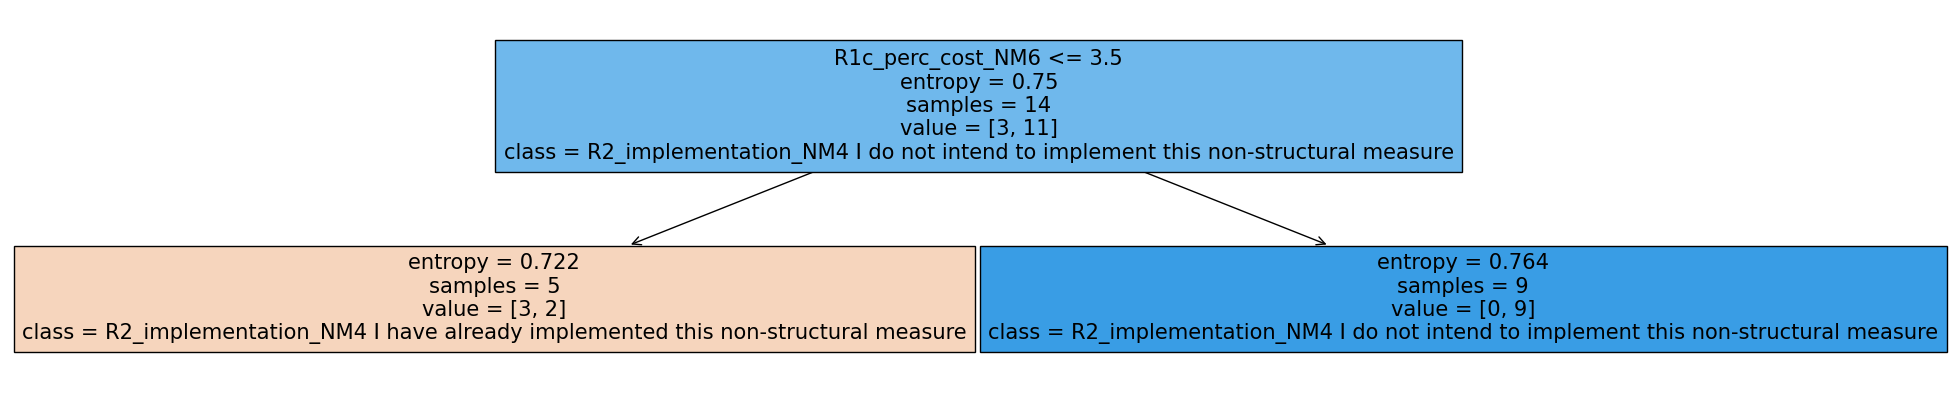

Accuracy is 0.6666666666666666
R2_implementation_NM5


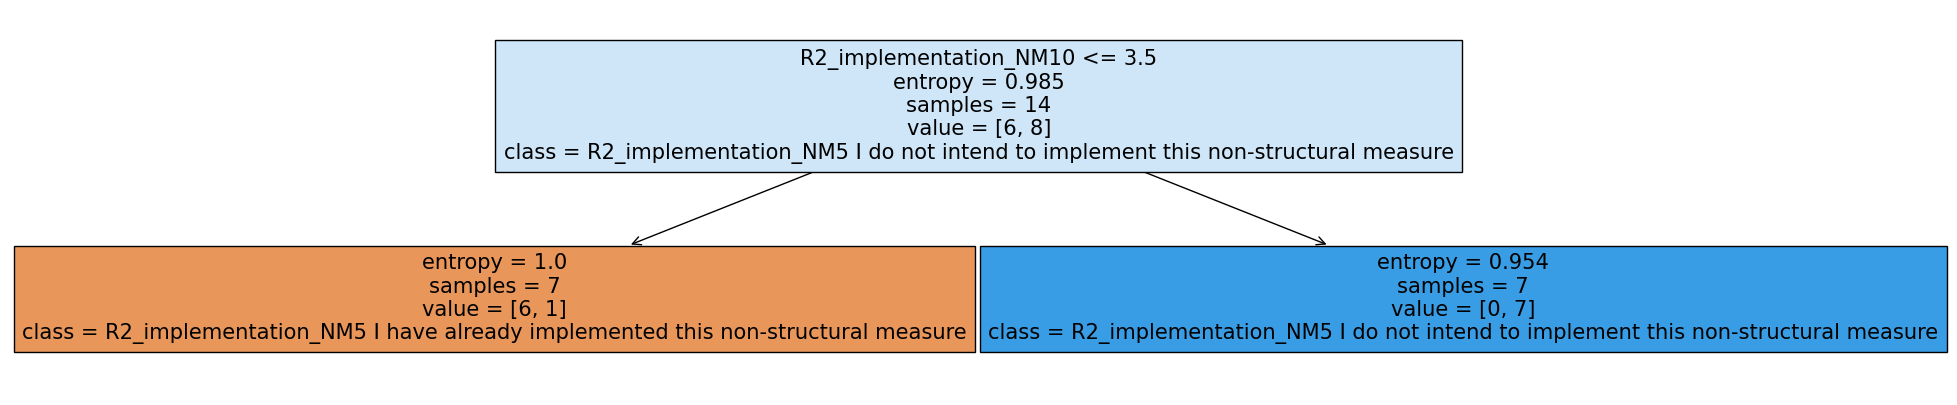

Accuracy is 0.8333333333333334
R2_implementation_SM3


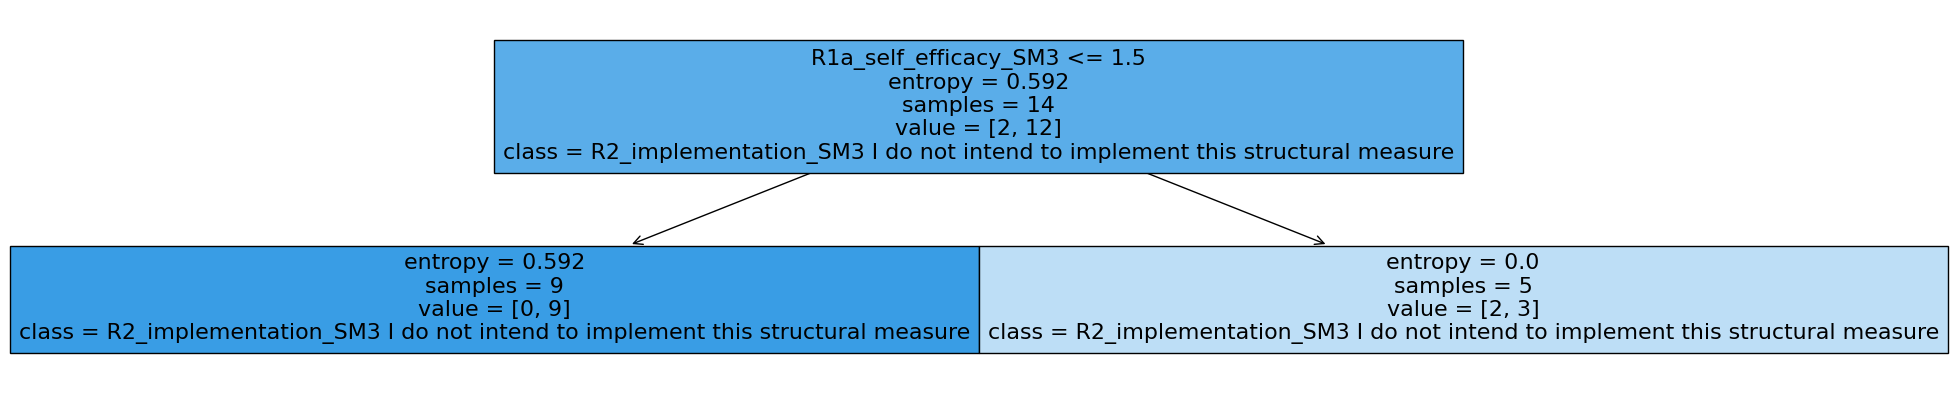

Accuracy is 1.0


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# { 
#     "alg": " HS512"
#     "typ": "JWT"
# }

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

for aim in chosen_aims:
    print(aim)
    aimRow = survey_questions[survey_questions["Variable Label\n (Data files)"] == aim]
    aimRow0 = aim + " " + str(aimRow.at[aimRow.index[0],"Value labels"])
    aimRow1 = aim + " " + str(aimRow.at[aimRow.index[-1],"Value labels"])
    X = aim_responses.loc[:, ~aim_responses.columns.isin([aim])].values
    Y = aim_responses.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)
    clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state=100, max_depth=5, min_samples_leaf=5)
    clf_entropy.fit(X_train,y_train)
    # Visualize the decision tree
    plt.figure(figsize=(25,5))
    plot_tree(clf_entropy, filled=True, feature_names=aim_responses.loc[:, ~aim_responses.columns.isin([aim])].columns, class_names = [aimRow0, aimRow1])
    plt.show()
    y_pred_en = clf_entropy.predict(X_test)
    print(("Accuracy is"),accuracy_score(y_test, y_pred_en))

In [24]:
survey_questions

,ADICO Category,Question number\n (Questionnaire file),Variable Label\n (Data files),Description,Values,Value labels,question_answers_combined
Q0_age_1.0,Attribute,Q0_age,Q0_age,Age,1.0,16-24,Age Response: 16-24
Q0_age_2.0,Attribute,Q0_age,Q0_age,Age,2.0,25-34,Age Response: 16-24Age Response: 25-34
Q0_age_3.0,Attribute,Q0_age,Q0_age,Age,3.0,35-44,Age Response: 16-24Age Response: 25-34Age Resp...
Q0_age_4.0,Attribute,Q0_age,Q0_age,Age,4.0,45-54,Age Response: 16-24Age Response: 25-34Age Resp...
Q0_age_5.0,Attribute,Q0_age,Q0_age,Age,5.0,55-64,Age Response: 16-24Age Response: 25-34Age Resp...
...,...,...,...,...,...,...,...
Q60a_parent_0.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,0.0,No,Are you the parent or guardian of any children...
Q60a_parent_1.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,1.0,Yes,Are you the parent or guardian of any children...
Q61_single_parent_0.0,Condition,Q61,Q61_single_parent,Are you a single parent?,0.0,No,Are you a single parent? Response: No
Q61_single_parent_1.0,Condition,Q61,Q61_single_parent,Are you a single parent?,1.0,Yes,Are you a single parent? Response: NoAre you a...


survey_questions.loc[survey_questions["Variable Label\n (Data files)"] == "feature", 'question_answers_combined'].loc[survey_questions["Values"] <= threshold]

survey_questions.loc[survey_questions["Variable Label\n (Data files)"] == "feature", 'question_answers_combined'].loc[survey_questions["Values"] <= threshold]

In [71]:
survey_questions[survey_questions["Variable Label\n (Data files)"] == "Q16_compens_gov"]

,ADICO Category,Question number\n (Questionnaire file),Variable Label\n (Data files),Description,Values,Value labels,question_answers_combined
Q16_compens_gov_nan,Condition,Q16,Q16_compens_gov,If your household is affected by a flood how m...,NaN,NaN,


R06a_media_freq


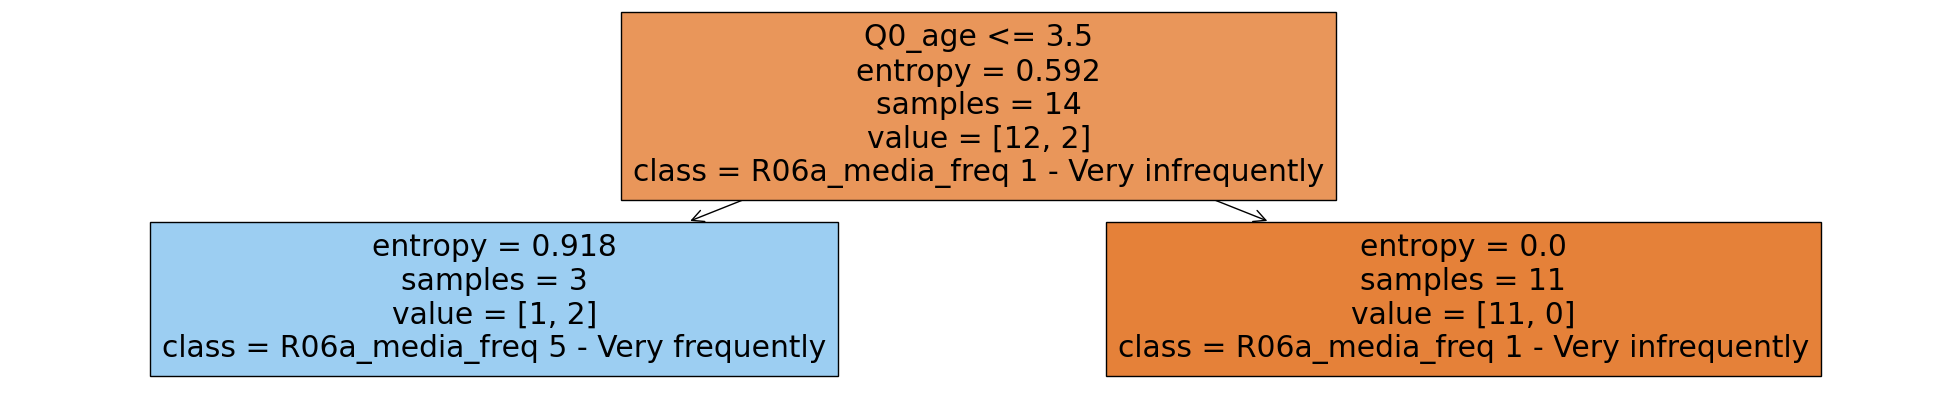

Accuracy is 0.6666666666666666
Selected Feature: Q0_age
Threshold (<=): 3.5
R06a_media_freq


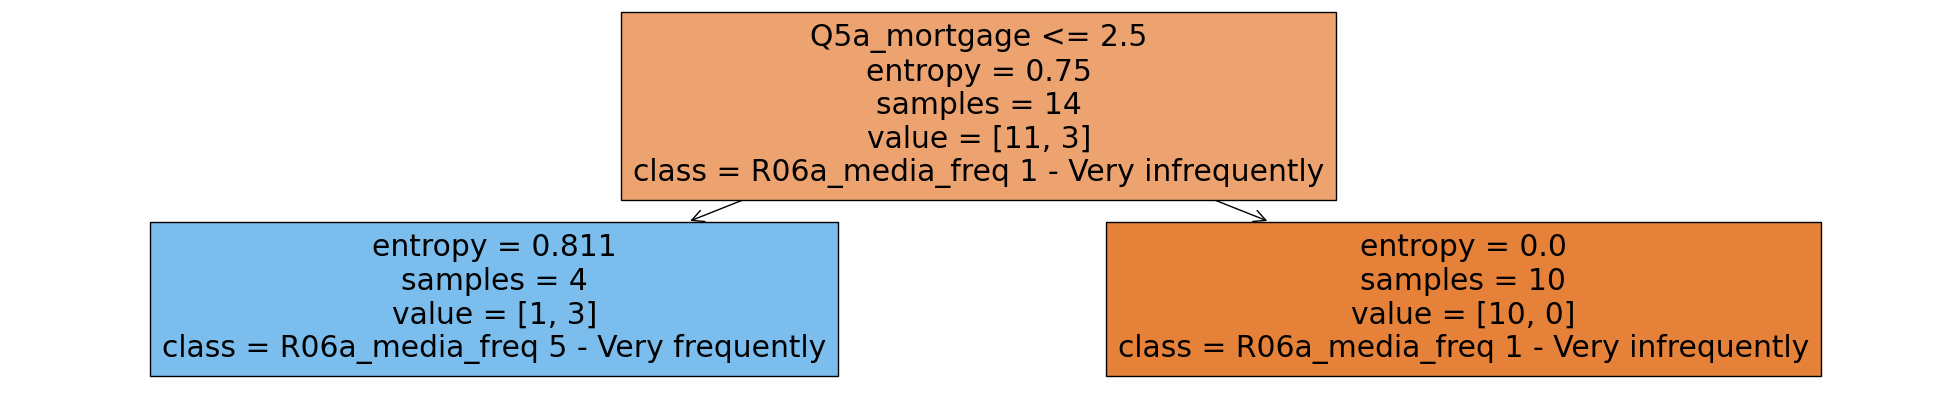

Accuracy is 0.6666666666666666
Selected Feature: Q5a_mortgage
Threshold (<=): 2.5
R06a_media_freq


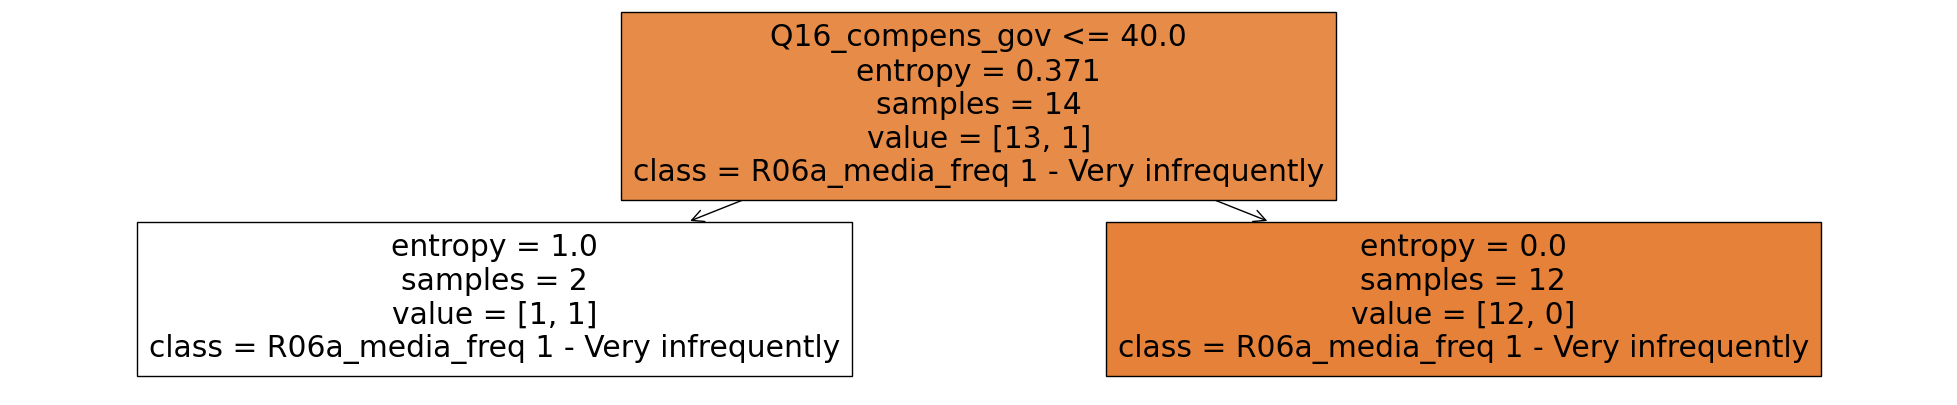

Accuracy is 0.6666666666666666
Selected Feature: Q16_compens_gov
Threshold (<=): 40.0
R06a_media_freq


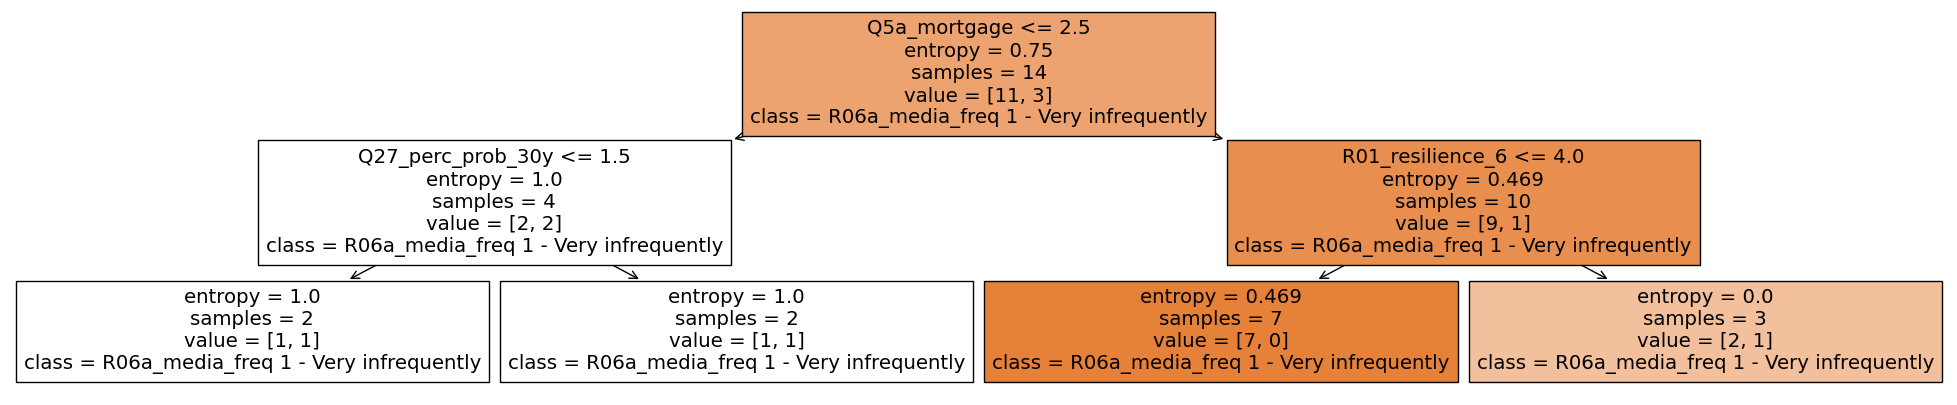

Accuracy is 1.0
Selected Feature: Q5a_mortgage
Threshold (<=): 2.5
Selected Feature: Q27_perc_prob_30y
Threshold (<=): 1.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: R01_resilience_6
Threshold (<=): 4.0
R06a_media_freq


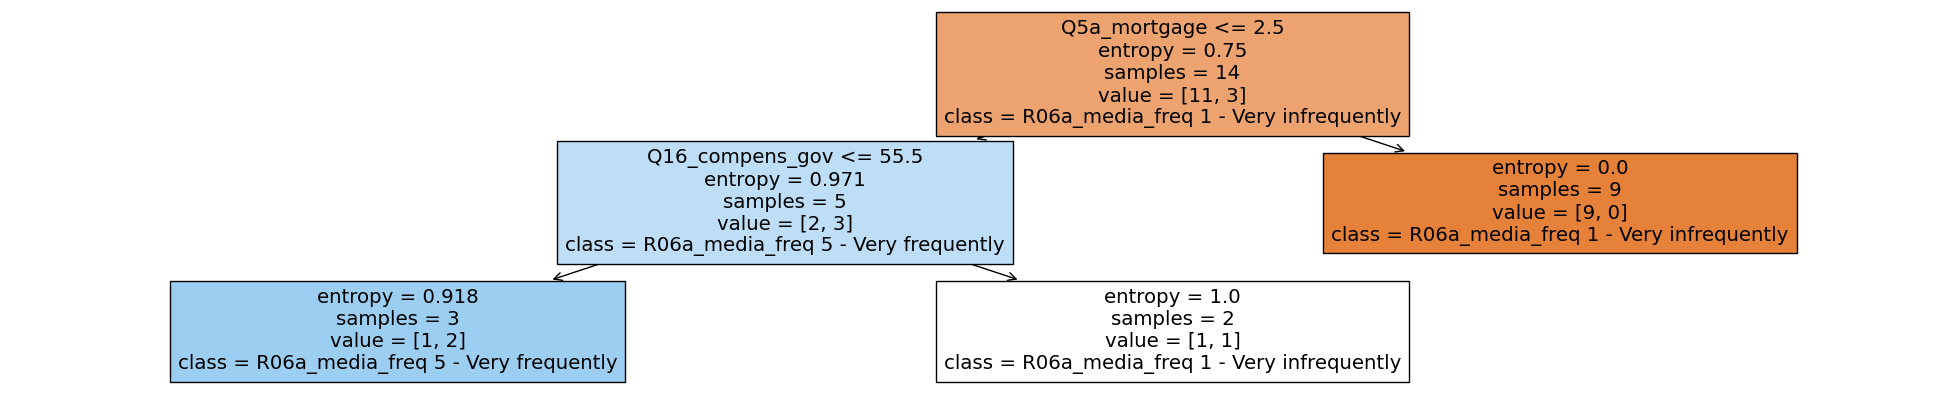

Accuracy is 1.0
Selected Feature: Q5a_mortgage
Threshold (<=): 2.5
Selected Feature: Q16_compens_gov
Threshold (<=): 55.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
R2_implementation_NM4


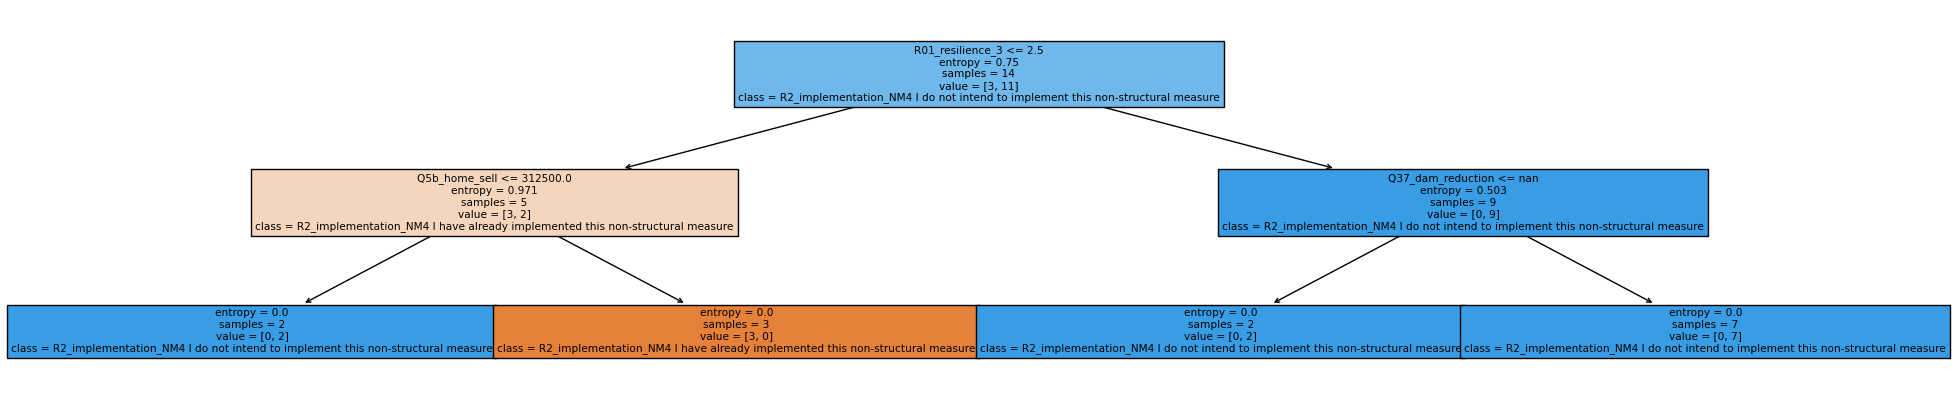

Accuracy is 0.8333333333333334
Selected Feature: R01_resilience_3
Threshold (<=): 2.5
Selected Feature: Q5b_home_sell
Threshold (<=): 312500.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q37_dam_reduction
Threshold (<=): nan
R2_implementation_NM4


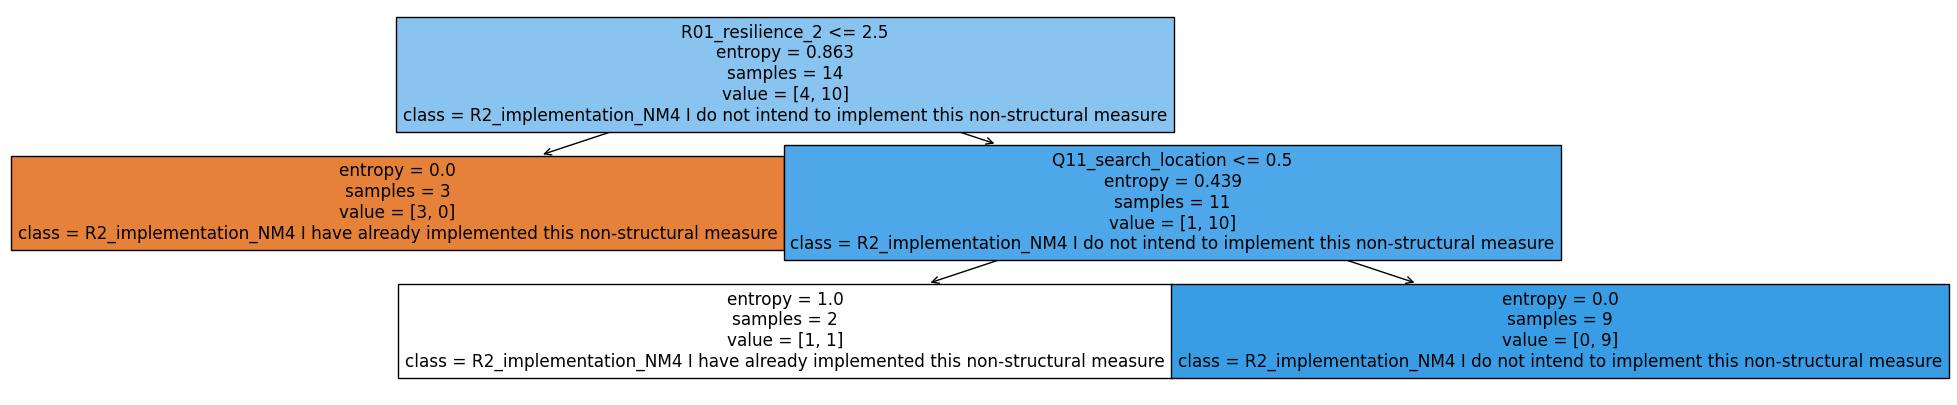

Accuracy is 0.3333333333333333
Selected Feature: R01_resilience_2
Threshold (<=): 2.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q11_search_location
Threshold (<=): 0.5
R2_implementation_NM4


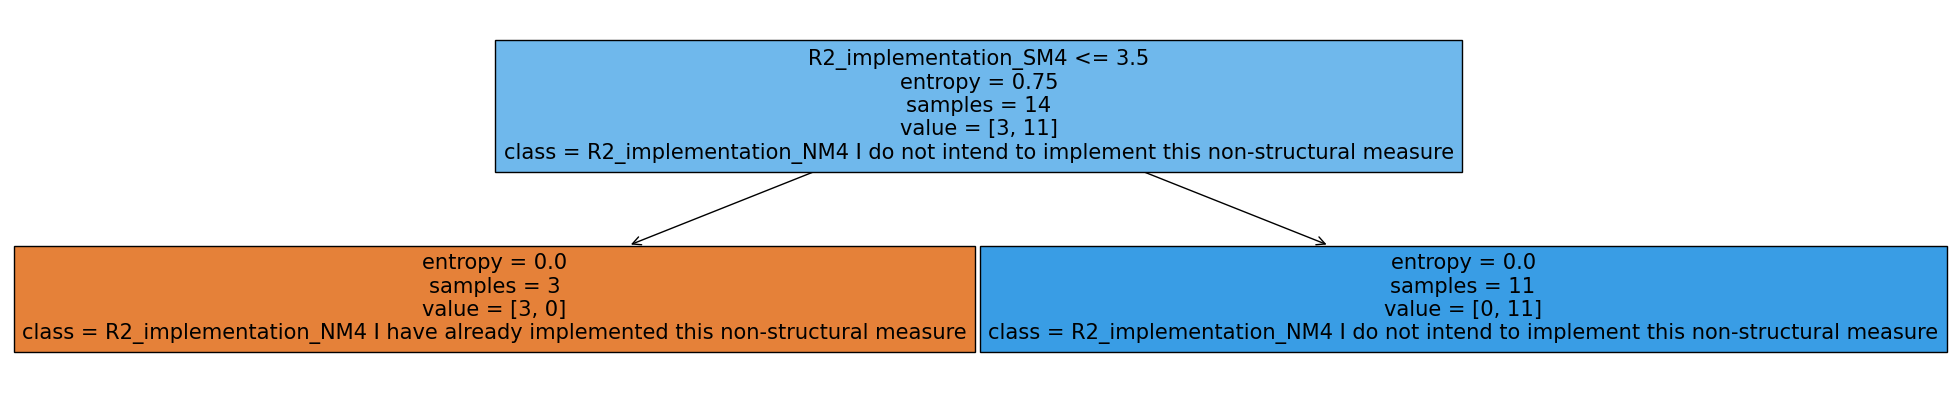

Accuracy is 0.8333333333333334
Selected Feature: R2_implementation_SM4
Threshold (<=): 3.5
R2_implementation_NM4


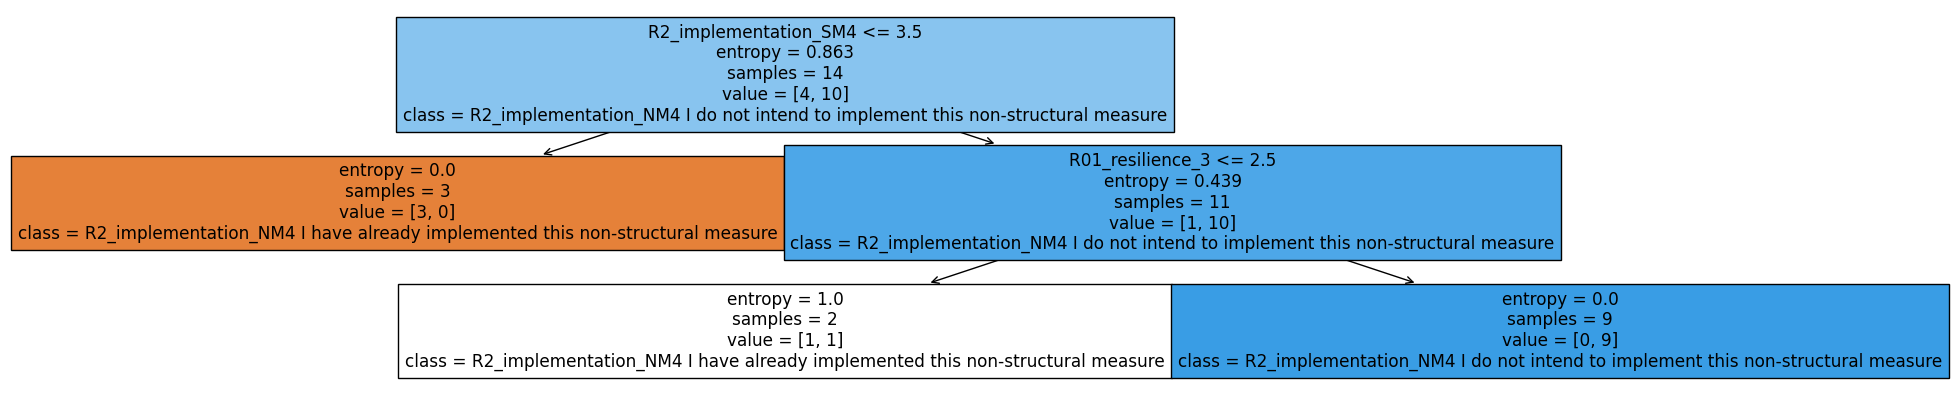

Accuracy is 0.6666666666666666
Selected Feature: R2_implementation_SM4
Threshold (<=): 3.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: R01_resilience_3
Threshold (<=): 2.5
R2_implementation_NM4


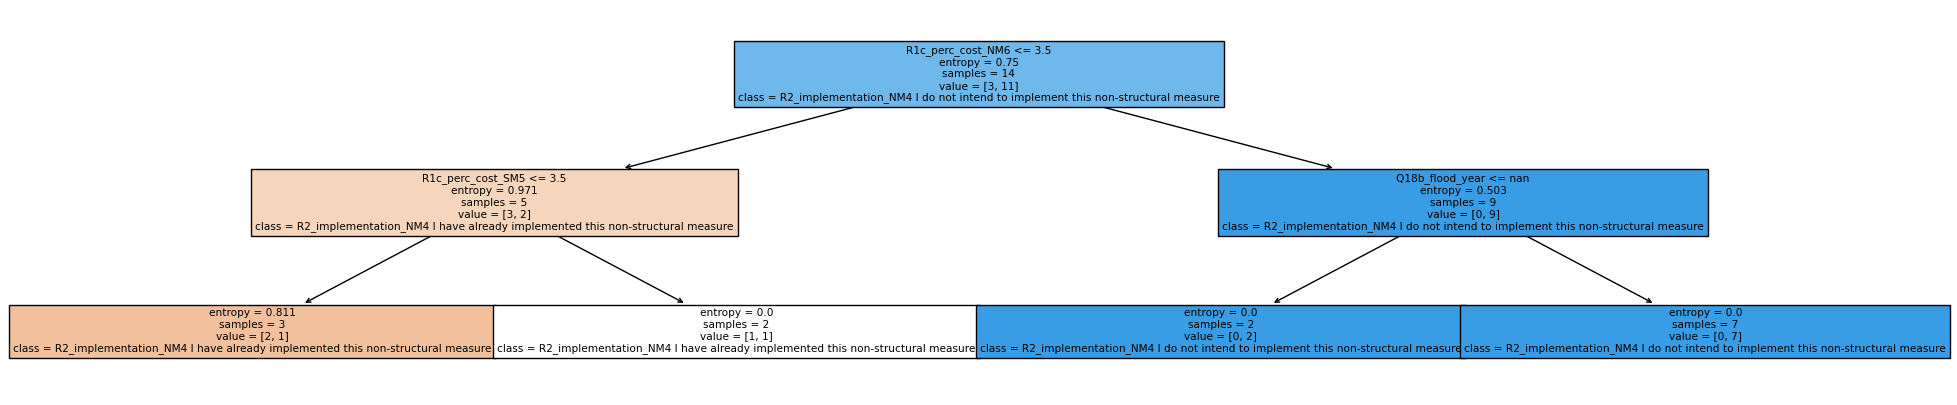

Accuracy is 0.6666666666666666
Selected Feature: R1c_perc_cost_NM6
Threshold (<=): 3.5
Selected Feature: R1c_perc_cost_SM5
Threshold (<=): 3.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q18b_flood_year
Threshold (<=): nan
R2_implementation_NM5


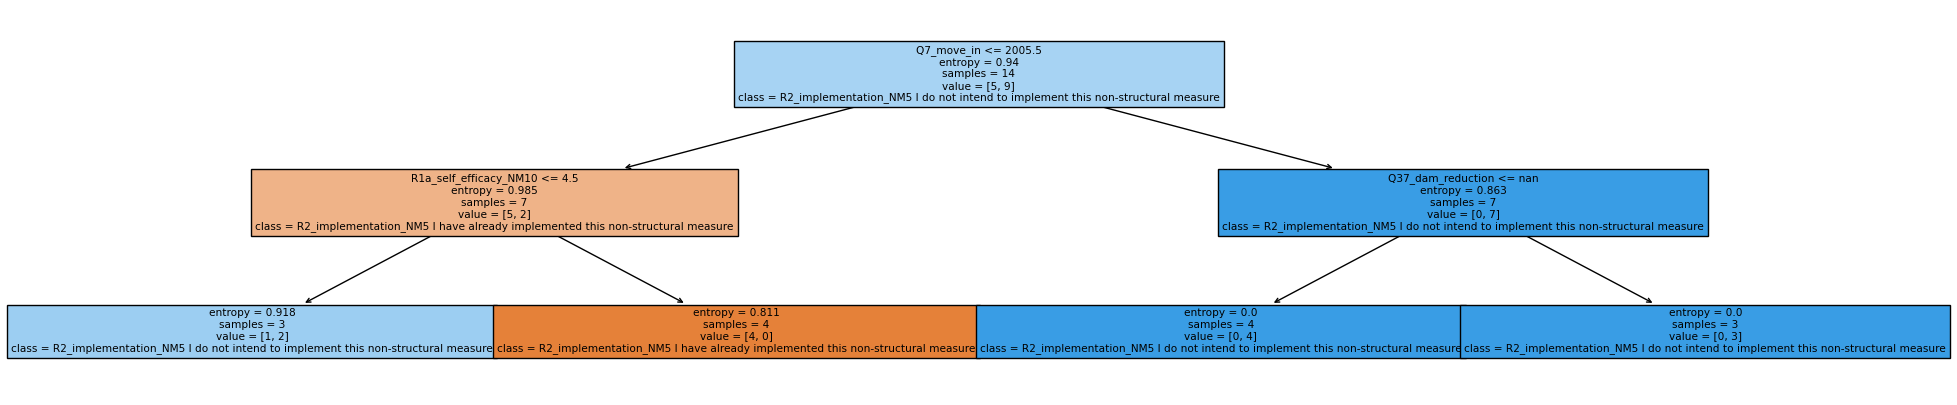

Accuracy is 0.5
Selected Feature: Q7_move_in
Threshold (<=): 2005.5
Selected Feature: R1a_self_efficacy_NM10
Threshold (<=): 4.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q37_dam_reduction
Threshold (<=): nan
R2_implementation_NM5


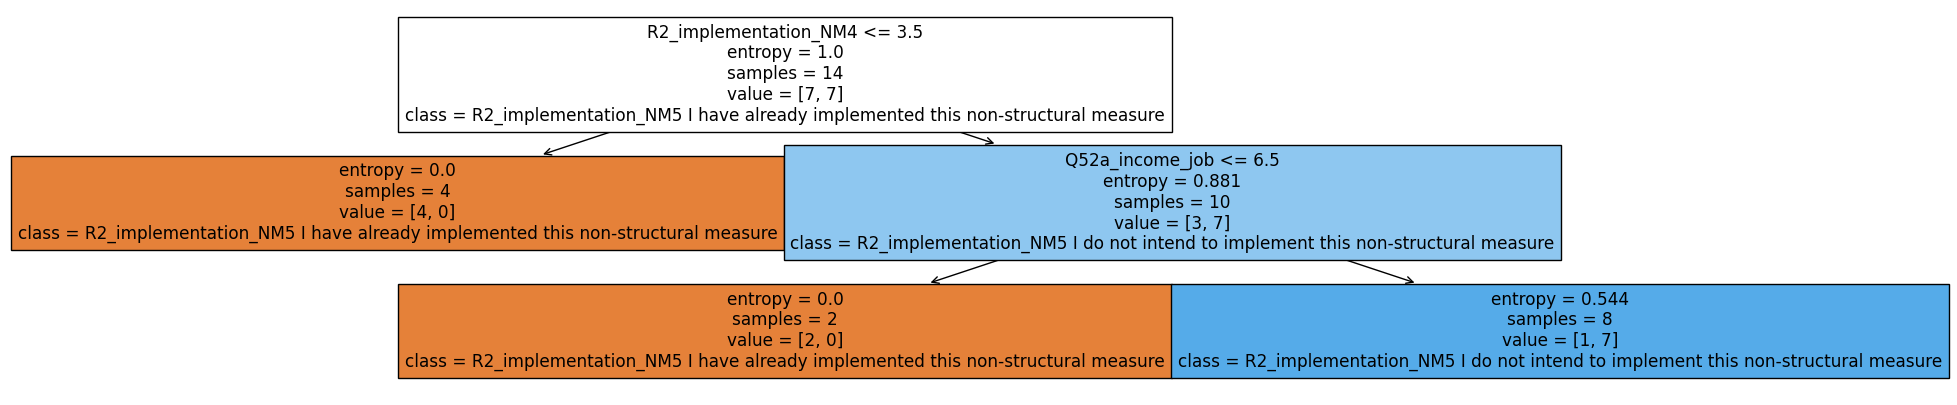

Accuracy is 0.8333333333333334
Selected Feature: R2_implementation_NM4
Threshold (<=): 3.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q52a_income_job
Threshold (<=): 6.5
R2_implementation_NM5


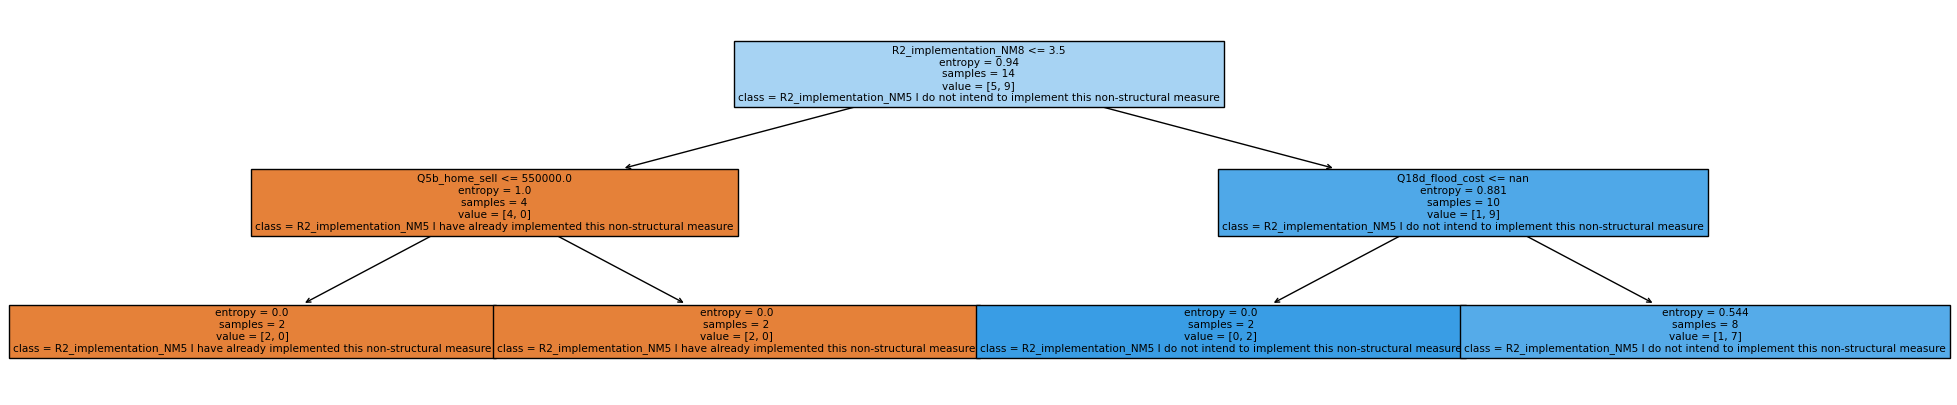

Accuracy is 0.5
Selected Feature: R2_implementation_NM8
Threshold (<=): 3.5
Selected Feature: Q5b_home_sell
Threshold (<=): 550000.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q18d_flood_cost
Threshold (<=): nan
R2_implementation_NM5


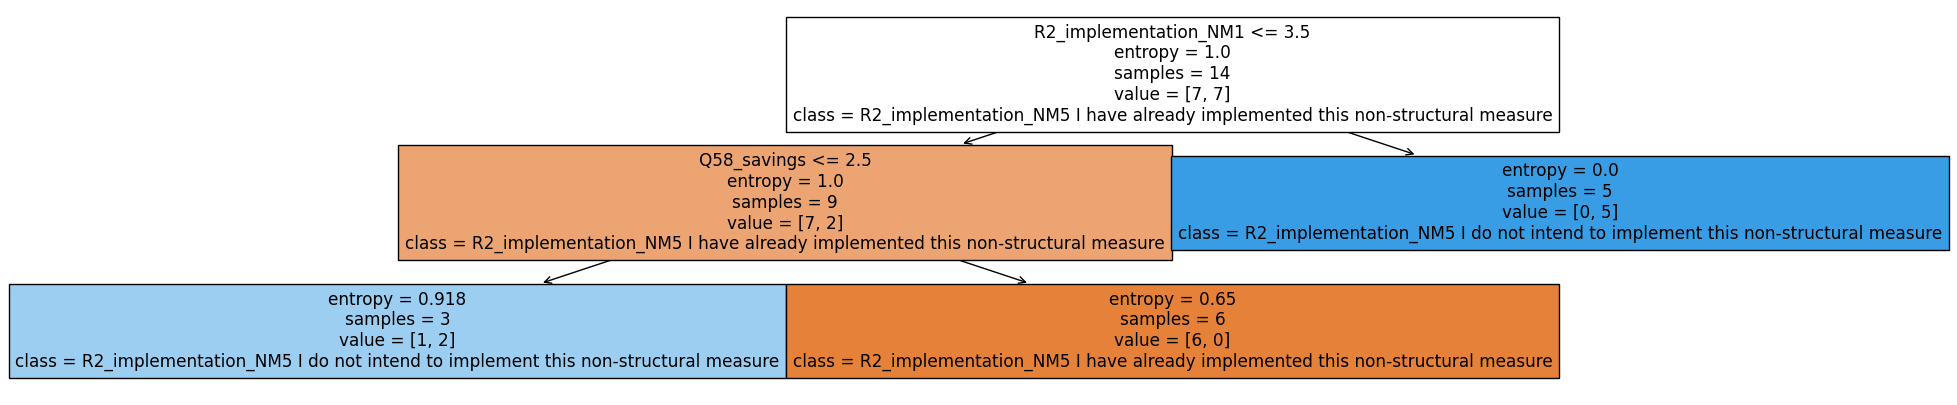

Accuracy is 1.0
Selected Feature: R2_implementation_NM1
Threshold (<=): 3.5
Selected Feature: Q58_savings
Threshold (<=): 2.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
R2_implementation_NM5


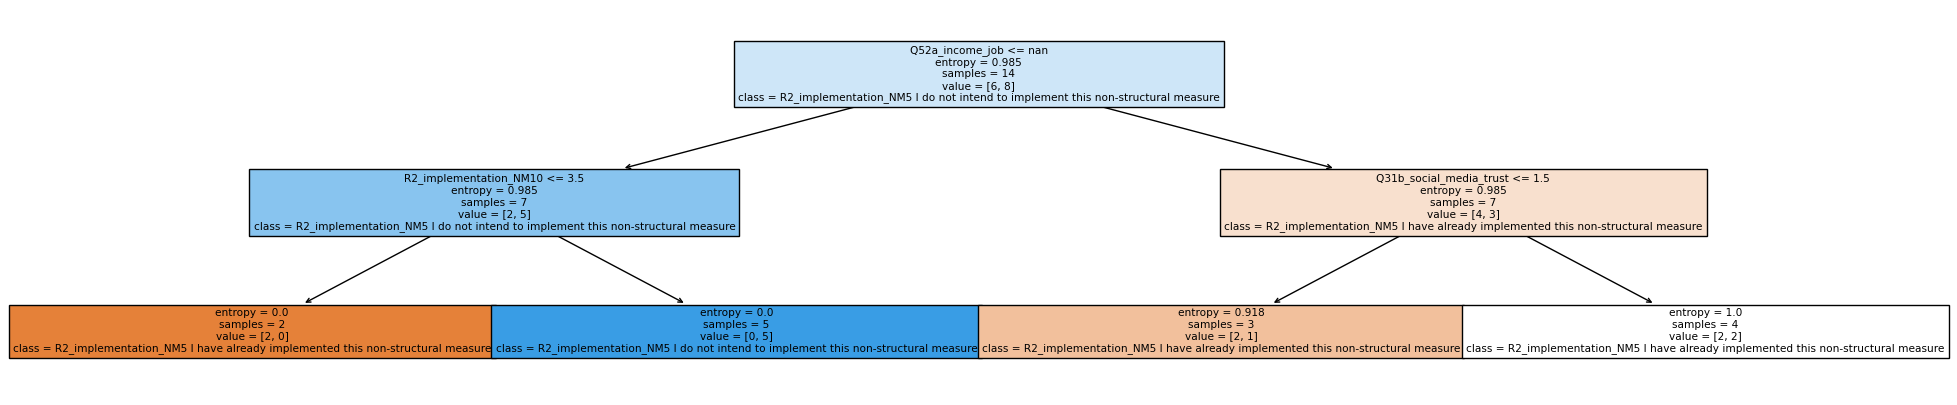

Accuracy is 0.5
Selected Feature: Q52a_income_job
Threshold (<=): nan
Selected Feature: R2_implementation_NM10
Threshold (<=): 3.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: Q31b_social_media_trust
Threshold (<=): 1.5
R2_implementation_SM3


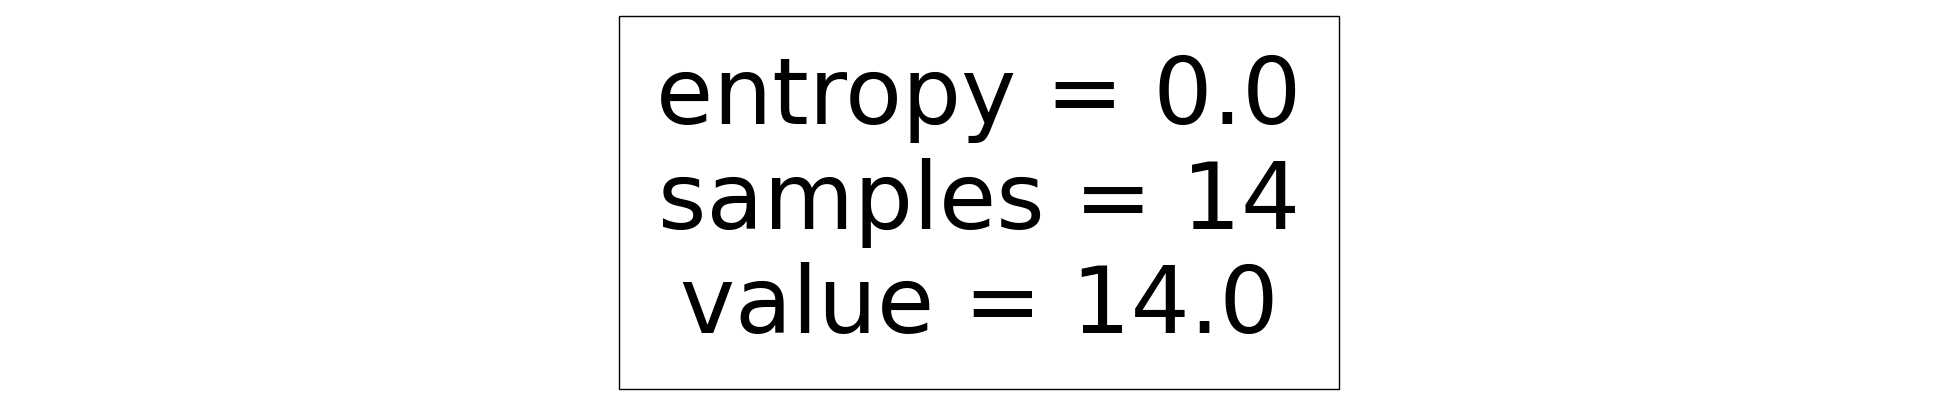

Accuracy is 0.6666666666666666
R2_implementation_SM3


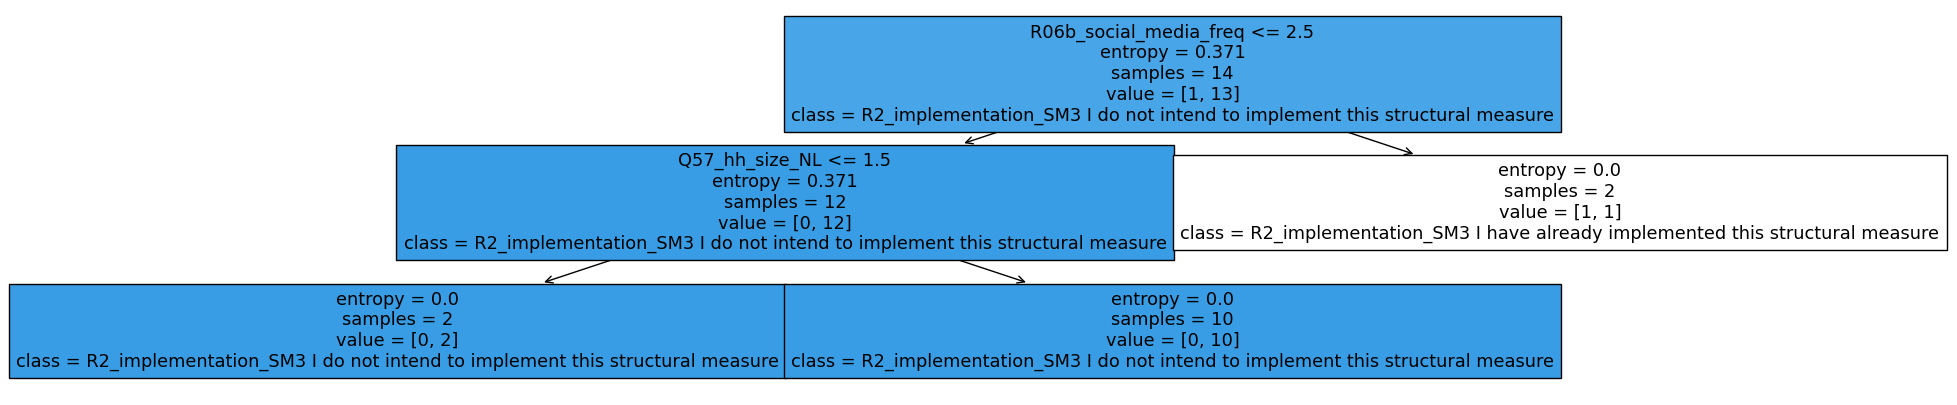

Accuracy is 1.0
Selected Feature: R06b_social_media_freq
Threshold (<=): 2.5
Selected Feature: Q57_hh_size_NL
Threshold (<=): 1.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0
R2_implementation_SM3


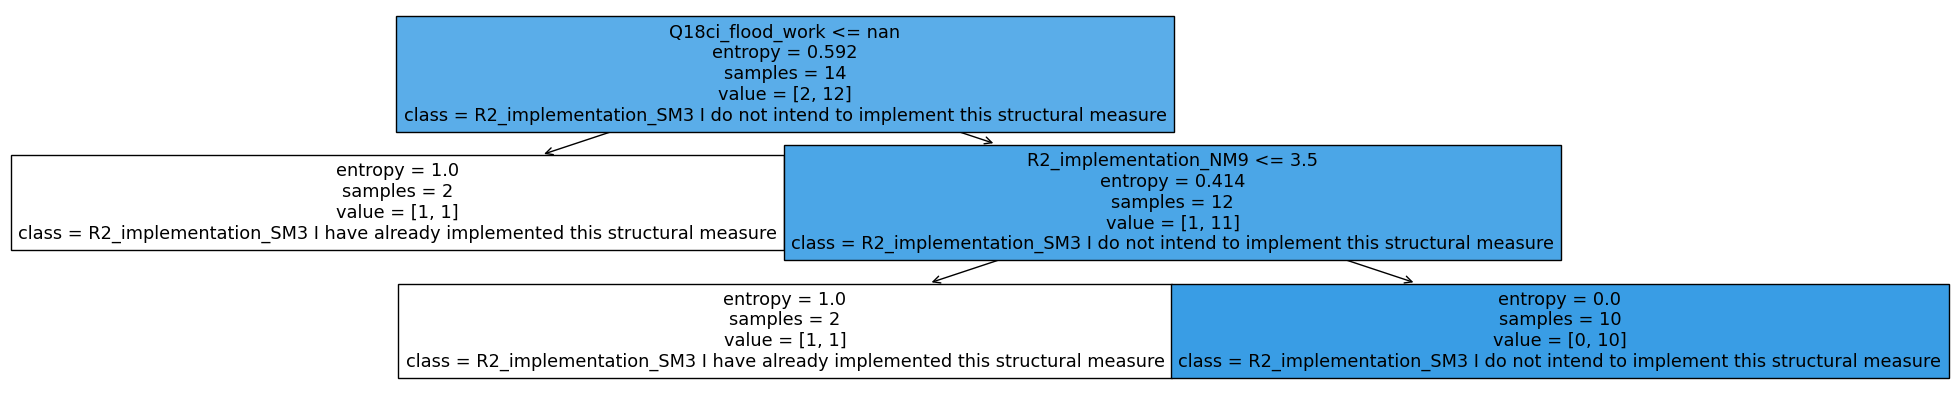

Accuracy is 0.8333333333333334
Selected Feature: Q18ci_flood_work
Threshold (<=): nan
Selected Feature: Q60_not_say
Threshold (<=): -2.0
Selected Feature: R2_implementation_NM9
Threshold (<=): 3.5
R2_implementation_SM3


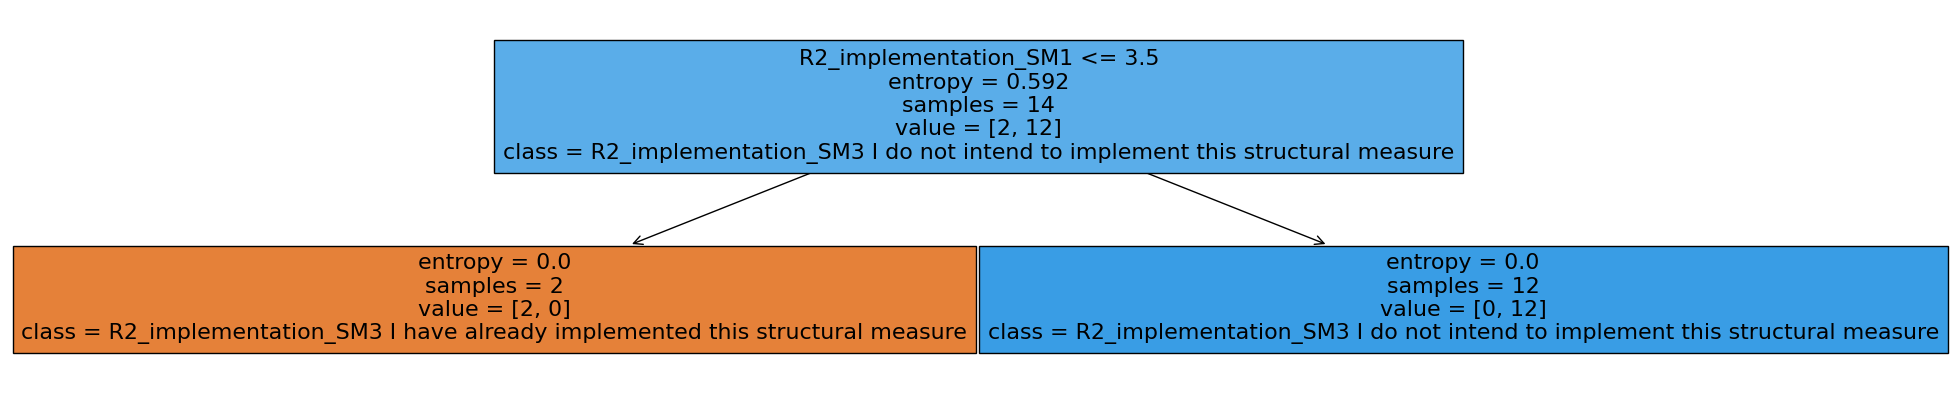

Accuracy is 1.0
Selected Feature: R2_implementation_SM1
Threshold (<=): 3.5
R2_implementation_SM3


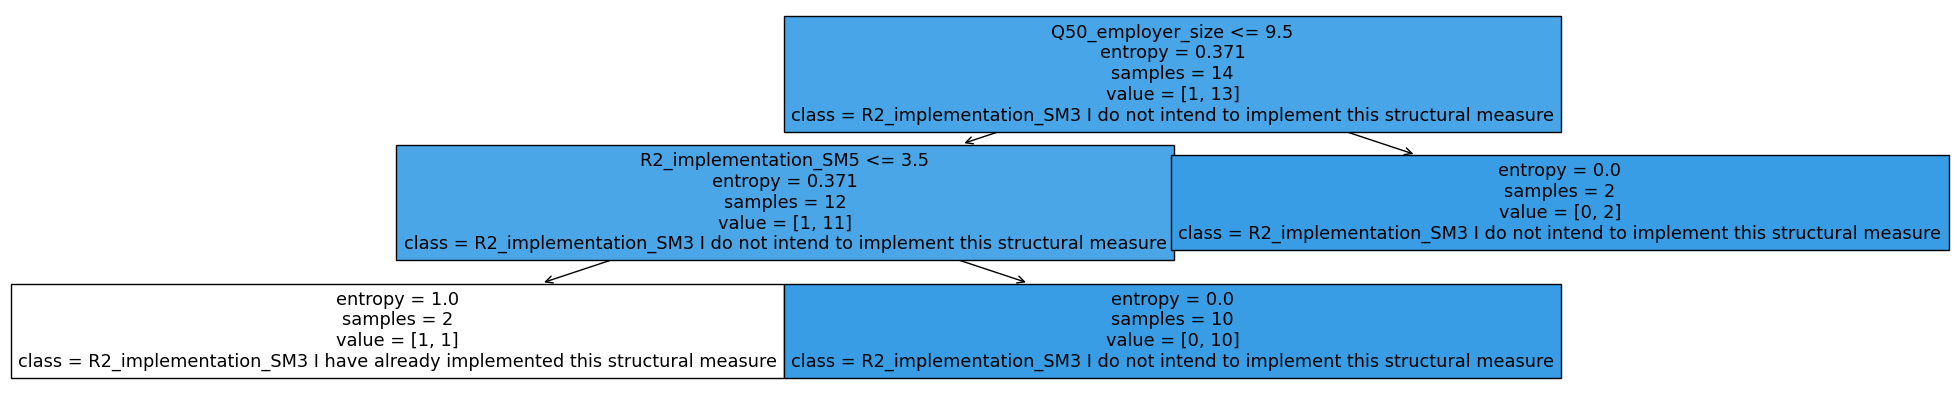

Accuracy is 0.8333333333333334
Selected Feature: Q50_employer_size
Threshold (<=): 9.5
Selected Feature: R2_implementation_SM5
Threshold (<=): 3.5
Selected Feature: Q60_not_say
Threshold (<=): -2.0


In [72]:
for aim in chosen_aims:
    for r_state in [12, 14, 25, 45, 87]:
        print(aim)
        aimRow = survey_questions[survey_questions["Variable Label\n (Data files)"] == aim]
        aimRow0 = aim + " " + str(aimRow.at[aimRow.index[0],"Value labels"])
        aimRow1 = aim + " " + str(aimRow.at[aimRow.index[-1],"Value labels"])
        X = aim_responses.loc[:, ~aim_responses.columns.isin([aim])].values
        Y = aim_responses.loc[:, aim].values

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = r_state)
        clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state=r_state, max_depth=2, min_samples_leaf=2)
        clf_entropy.fit(X_train,y_train)
        # Visualize the decision tree
        plt.figure(figsize=(25,5))
        plot_tree(clf_entropy, filled=True, feature_names=aim_responses.loc[:, ~aim_responses.columns.isin([aim])].columns, class_names = [aimRow0, aimRow1])
        plt.show()
        y_pred_en = clf_entropy.predict(X_test)
        print(("Accuracy is"),accuracy_score(y_test, y_pred_en))
        tree = clf_entropy.tree_
        selected_features = [aim_responses.loc[:, ~aim_responses.columns.isin([aim])].columns[feature] for feature in tree.feature][0:-2]
        thresholds = tree.threshold[0:-2]
        for feature, threshold in zip(selected_features, thresholds):
            print("Selected Feature:", feature)
            print("Threshold (<=):", threshold)
        

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

responses_nadrop = aim_responses.dropna(axis=1)


for aim in chosen_aims:
    print(aim)
    X = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].values
    Y = responses_nadrop.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
    
    # Create and train logistic regression model
    clf_logreg = LogisticRegression(max_iter=1000)
    clf_logreg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf_logreg.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(("Accuracy is"), accuracy)

    # Get feature names
    feature_names = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].columns

    # Get coefficients
    coefficients = clf_logreg.coef_[0]

    # Create a DataFrame to display feature names and corresponding coefficients
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

    # Sort DataFrame by absolute coefficient values to identify most impactful features
    coef_df["Absolute Coefficient"] = coef_df["Coefficient"].abs()
    coef_df_sorted = coef_df.sort_values(by="Absolute Coefficient", ascending=False)

    # Display the top features impacting the prediction
    print("Top features impacting the prediction:")
    print(coef_df_sorted.head())



R06a_media_freq
Accuracy is 0.6666666666666666
Top features impacting the prediction:
                   Feature  Coefficient  Absolute Coefficient
33          Q14_early_warn    -0.137154              0.137154
131           Q46_dikes_NL     0.129086              0.129086
130  R07_adaptation_others    -0.102253              0.102253
46           R02_perc_prob    -0.084260              0.084260
5         Q1_home_ID_NL_US    -0.063724              0.063724
R2_implementation_NM4
Accuracy is 0.3333333333333333
Top features impacting the prediction:
                       Feature  Coefficient  Absolute Coefficient
5             Q1_home_ID_NL_US    -0.131175              0.131175
14                 Q8_move_out     0.096210              0.096210
140                Q58_savings    -0.081387              0.081387
46               R02_perc_prob     0.051327              0.051327
138  Q56_savings_change_future    -0.042332              0.042332
R2_implementation_NM5
Accuracy is 0.3333333333333333
T

In [14]:
shared_strategies = pd.DataFrame(columns=["Attribute", "Attribute_value","Condition", "Condition_value","Aim", "Aim_value", "Count"])
# Iterate over each attribute label in the question_adico_mapping DataFrame
for AttributeLabel in Attributes:
    # Check if the attribute label exists in the NLDataWave1 DataFrame
    if AttributeLabel not in NLDataWave1.columns:
        continue

    # Group NLDataWave1 DataFrame by the current attribute label
    attribute_set = NLDataWave1.groupby(AttributeLabel)
    # Iterate over each group in the attribute set
    for a, a_set in attribute_set:
        # Calculate the count of rows in the current group
        a_count = len(a_set)
        
        # Iterate over each condition label in the question_adico_mapping DataFrame
        for ConditionLabel in Conditions:
            # Check if the condition label exists in the NLDataWave1 DataFrame
            if ConditionLabel not in NLDataWave1.columns:
                continue
            
            # Group the current attribute group by the current condition label
            ab_set = a_set.groupby(ConditionLabel)
            # Iterate over each group in the ab_set
            for b, ab_set_group in ab_set:
                # Calculate the count of rows in the current group
                ab_count = len(ab_set_group)
                
                # Iterate over each aim label in the question_adico_mapping DataFrame
                for AimLabel in Aims:
                    # Check if the aim label exists in the NLDataWave1 DataFrame
                    if AimLabel not in NLDataWave1.columns:
                        continue
                    
                    # Group the current condition group by the current aim label
                    abc_set = ab_set_group.groupby(AimLabel)
                    # Iterate over each group in the abc_set
                    for c, abc_set_group in abc_set:
                        # Calculate the count of rows in the current group
                        abc_count = len(abc_set_group)
                        # Print the result if the count is greater than or equal to 10
                        if abc_count >= 11:
                            new_strat = pd.DataFrame([[AttributeLabel, a, ConditionLabel, b, AimLabel, c, abc_count]], columns=["Attribute", "Attribute_value","Condition", "Condition_value","Aim", "Aim_value", "Count"])
                            shared_strategies = pd.concat([shared_strategies, new_strat])


In [15]:
shared_strategies

,Attribute,Attribute_value,Condition,Condition_value,Aim,Aim_value,Count
0,Q0_education_NL,3,Q17_compens_other,0,R2_implementation_SM2,6,11
0,Q0_education_NL,3,Q60_not_say,0,R2_implementation_SM2,6,11
0,Q0_education_NL,3,Q17_compens_noone,0,R2_implementation_SM2,6,11
0,Q0_education_NL,3,R2_implementation_SM2,6,R2_implementation_SM2,6,11
0,Q0_education_NL,3,Q18_flood_exp,0,R2_implementation_SM2,6,11
...,...,...,...,...,...,...,...
0,Q2_floors_1,0.0,Q60_no,1,Q15_responsibility,3,11
0,Q2_floors_1,0.0,Q60_no,1,R2_implementation_SM1,6,14
0,Q2_floors_1,0.0,Q60_no,1,R2_implementation_SM6,6,14
0,Q2_floors_1,0.0,Q60_no,1,R2_implementation_SM3,6,14


In [16]:
# Segment data by 'Q0_gender'
gender_groups = AllWave1.groupby('Q0_gender')

# Prepare a structure to hold the results of correlation analysis for each gender group
results = {}

# Iterate over each gender group and calculate correlations between selected conditions and aims
for gender, group in gender_groups:
    # Filter the group data for selected conditions and aims
    subgroup_data = group[selected_conditions + selected_aims].dropna()
    
    # Calculate the correlation matrix for the subgroup
    correlation_matrix = subgroup_data.corr()
    
    # Extract correlations between conditions and aims
    condition_aim_correlations = correlation_matrix.loc[selected_conditions, selected_aims]
    
    # Store the results
    results[gender] = condition_aim_correlations

# Due to the selection of a large number of conditions and aims, and for simplicity,
# let's display the results for the first gender group as an example
results[list(results.keys())[0]]


NameError: name 'selected_conditions' is not defined

In [ ]:
AllWave1['Q18c_flood_health'].value_counts()

Q18c_flood_health
0.0    12
1.0     7
Name: count, dtype: int64

In [ ]:
# To adjust the correlation calculation considering only those with 15 or more rows of non-null data,
# we'll filter out column pairs that do not meet this criterion before calculating correlations.

# Define a function to filter correlations based on a minimum number of non-null observations
def filter_correlations(dataframe, min_count=15):
    valid_correlations = {}
    columns = dataframe.columns
    
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            subset = dataframe[[columns[i], columns[j]]].dropna()
            if len(subset) >= min_count:
                corr = subset[columns[i]].corr(subset[columns[j]])
                key = (columns[i], columns[j])
                valid_correlations[key] = corr
    
    # Convert to a Series for easier handling
    valid_correlation_series = pd.Series(valid_correlations).sort_values()
    
    return valid_correlation_series

# Identify numeric columns for correlation analysis
numeric_columns = AllWave1.select_dtypes(include=[np.number]).columns.tolist()

# Calculate the correlation matrix
# Calculate filtered correlations for the entire dataset
filtered_correlations = filter_correlations(AllWave1[numeric_columns])

# Most correlated pairs with the adjustment
adjusted_most_correlated_pairs = filtered_correlations.nlargest(5)

# Least (or negatively) correlated pairs with the adjustment
adjusted_least_correlated_pairs = filtered_correlations.nsmallest(5)

adjusted_most_correlated_pairs, adjusted_least_correlated_pairs

c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_bas

(Q5_home_tenure         Q4_home_size_US     0.998608
 Q14_early_warn         Q4_home_size_US     0.998052
 Q17_compens_dont_know  Q0_employment_CN    0.996309
 R08_economic_comfort   Q0_employment_CN    0.995572
 Q4_home_size_CN_ID_NL  Q0_employment_CN    0.993963
 dtype: float64,
 Q0_postcode        Q0_employment_CN        -0.997709
 Q50_employer_size  Q0_education_CN         -0.896987
 Q18c_flood_health  R2_implementation_SM1   -0.787810
 Q60_child          Q60_no                  -0.714540
 R03_perc_damage    Q0_education_CN         -0.702187
 dtype: float64)

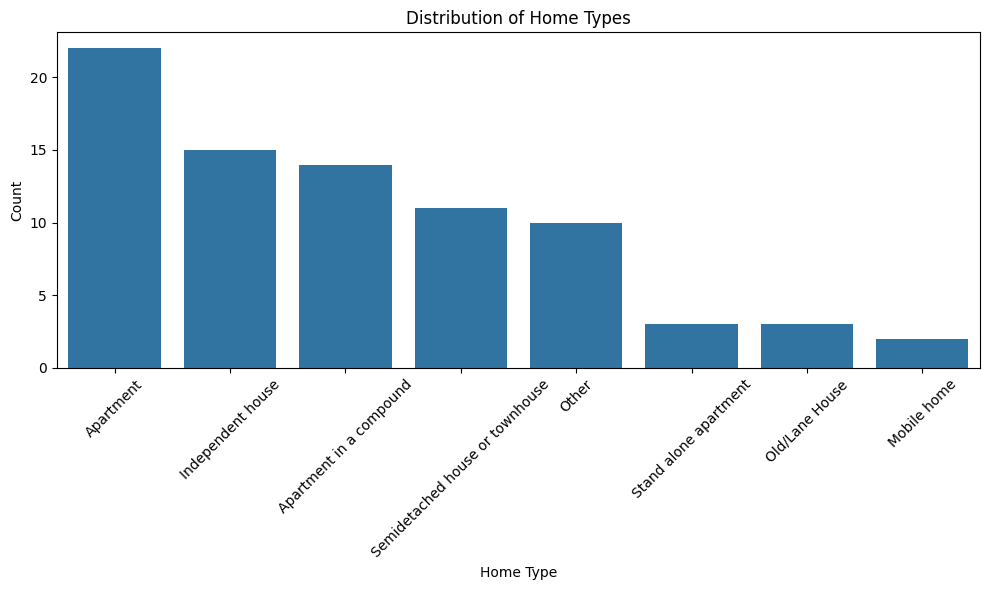

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping numerical values to home types
home_type_mapping_ID_NL_US = {
    1.: 'Apartment',
    2.: 'Semidetached house or townhouse',
    3.: 'Independent house',
    4.: 'Mobile home',
    97.: 'Other'
}
home_type_mapping_CN = {
    1.: 'Old/Lane House',
    2.: 'Stand alone apartment',
    3.: 'Apartment in a compound',
    4.: 'Villa',
    5.:	"Serviced Apartment",
    97.:	"Other",
    98.:	"Don't know"
}

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_ID_NL_US' with the provided mapping
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].map(home_type_mapping_ID_NL_US)

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_CN' with the provided mapping
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].map(home_type_mapping_CN)

# Fill NaN values in 'Q1_home_ID_NL_US' with the values from 'Q1_home_CN_mapped'
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].fillna(AllWave1['Q1_home_CN'])


# Visualise the distribution of home types
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', order=AllWave1['Q1_home_ID_NL_US'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

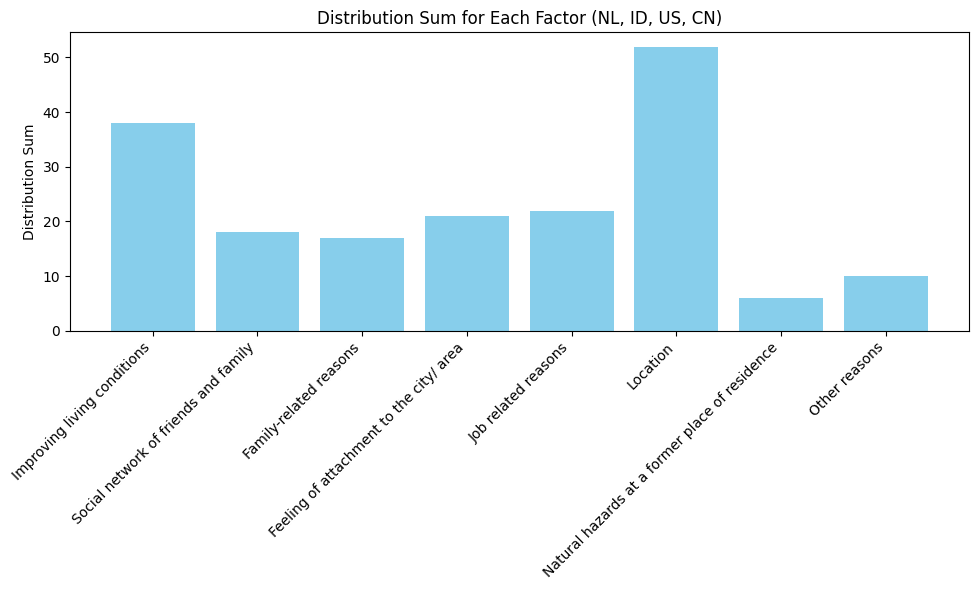

In [ ]:
# Calculate distribution sum for each factor
distribution_sums = []
factors = []

# Define mapping of response options to factors
factor_mapping = {
    'Improving living conditions': 'Q11_search_improve',
    'Social network of friends and family': 'Q11_search_social',
    'Family-related reasons': 'Q11_search_family',
    'Feeling of attachment to the city/ area': 'Q11_search_area',
    'Job related reasons': 'Q11_search_job',
    'Location': 'Q11_search_location',
    'Natural hazards at a former place of residence': 'Q11_search_hazard',
    'Other reasons': 'Q11_search_other',
}

for factor, column in factor_mapping.items():
    distribution_sum = AllWave1[column].sum()
    factors.append(factor)
    distribution_sums.append(distribution_sum)

# Create distribution plot
plt.figure(figsize=(10, 6))
plt.bar(factors, distribution_sums, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Distribution Sum')
plt.title('Distribution Sum for Each Factor (NL, ID, US, CN)')
plt.tight_layout()
plt.show()

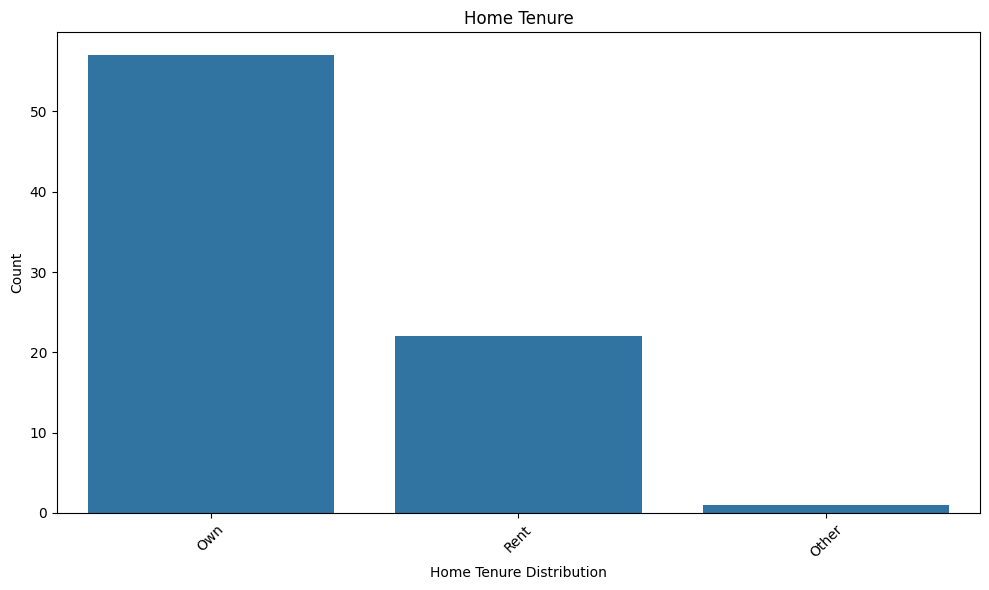

In [ ]:
# Mapping for home tenure
rent_own_mapping = {
    1: 'Rent',
    2: "Own",
    97: 'Other',
}

# Apply mapping
AllWave1['rent_own_mapping'] = AllWave1['Q5_home_tenure'].map(rent_own_mapping)

# Visualize the distribution of home tenure
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='rent_own_mapping', order=AllWave1['rent_own_mapping'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Home Tenure')
plt.xlabel('Home Tenure Distribution')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

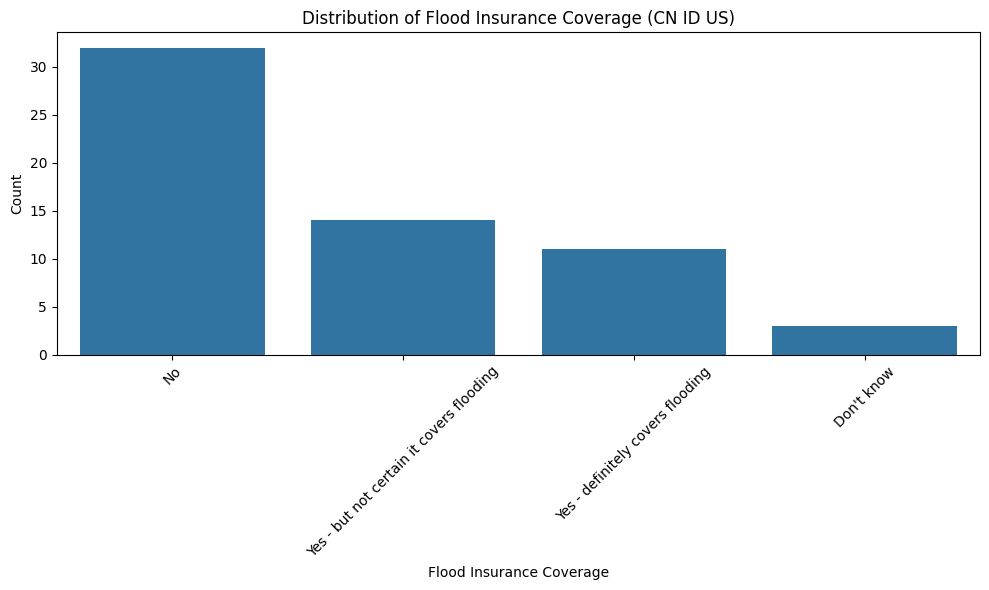

In [ ]:
# Mapping for flood insurance coverage
insurance_coverage_mapping = {
    1: 'Yes - definitely covers flooding',
    2: "Yes - but not certain it covers flooding",
    3: 'No',
    98: "Don't know"
}

# Apply mapping
AllWave1['insurance_coverage_mapped'] = AllWave1['Q41_ins_CN_ID_US'].map(insurance_coverage_mapping)

# Visualize the distribution of insurance coverage
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='insurance_coverage_mapped', order=AllWave1['insurance_coverage_mapped'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Flood Insurance Coverage (CN ID US)')
plt.xlabel('Flood Insurance Coverage')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

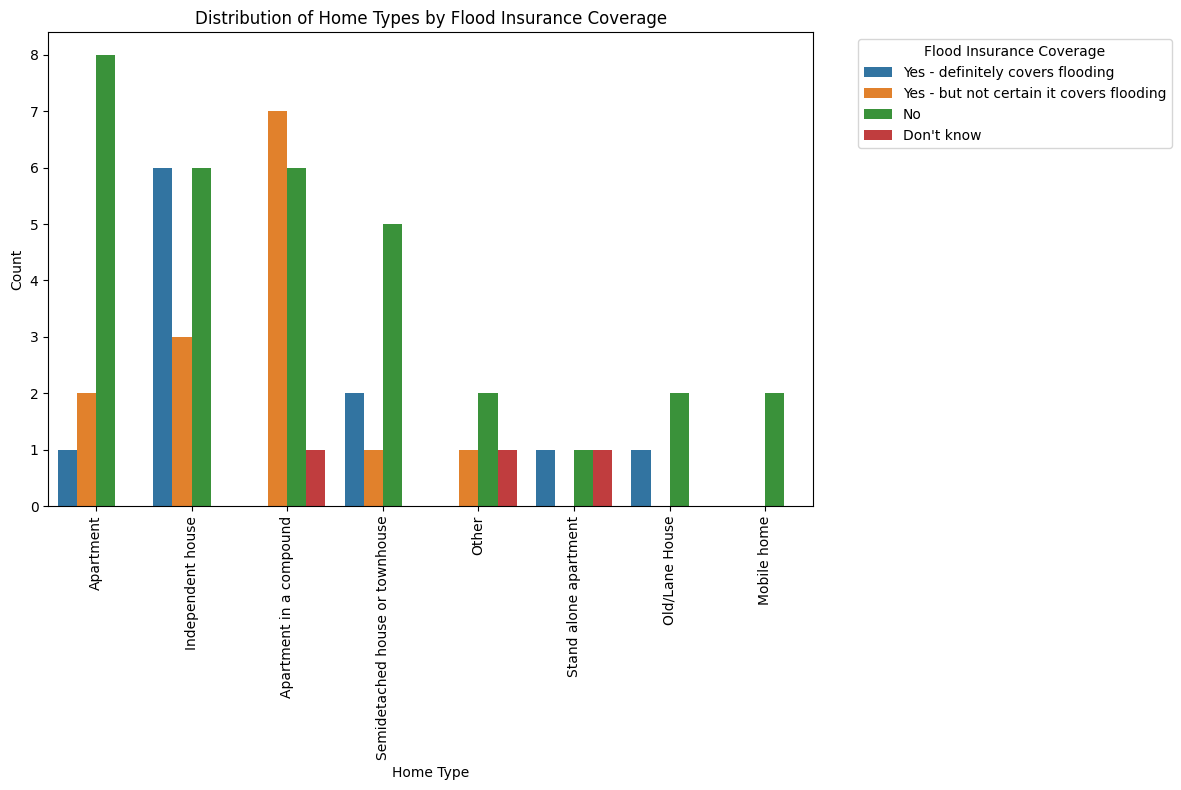

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', hue='insurance_coverage_mapped', 
              order=AllWave1['Q1_home_ID_NL_US'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Types by Flood Insurance Coverage')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


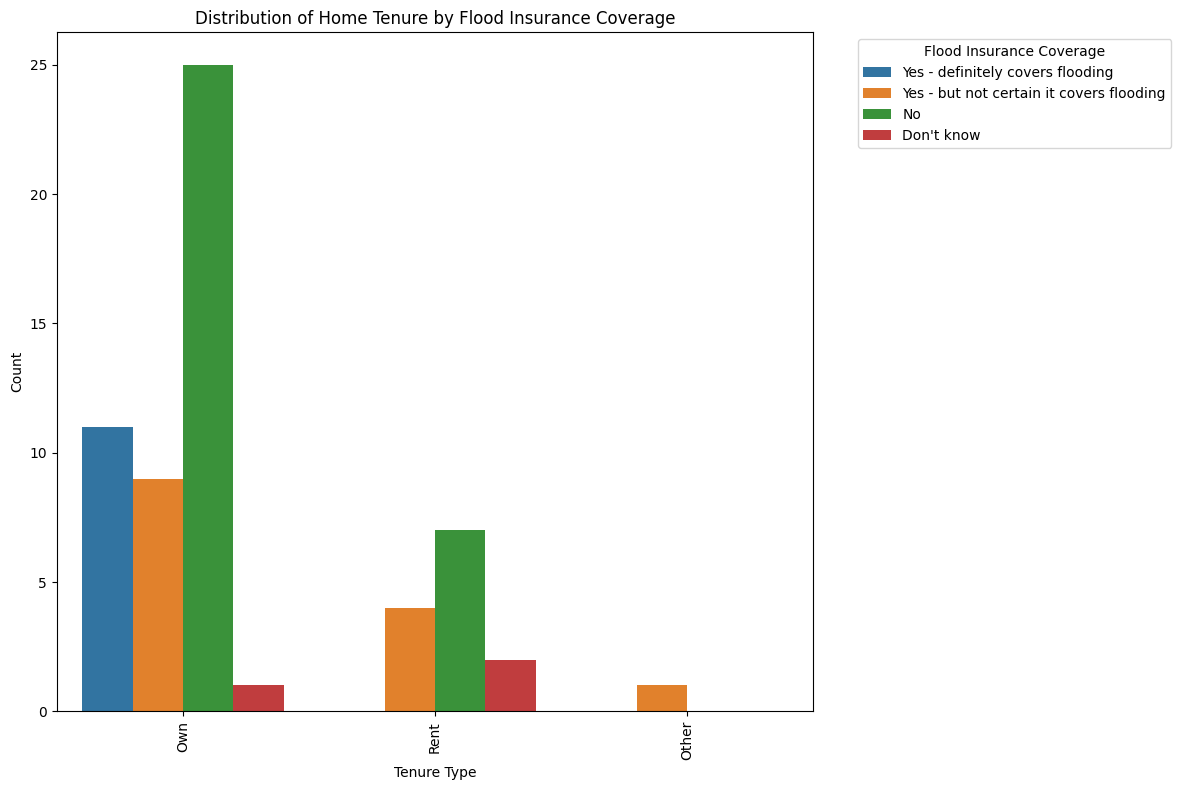

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='rent_own_mapping', hue='insurance_coverage_mapped', order=AllWave1['rent_own_mapping'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Tenure by Flood Insurance Coverage')
plt.xlabel('Tenure Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
correlation_data = AllWave1[["Q18_flood_exp", "R05_worry", "R2_implementation_NM4"]].copy()
# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix

,Q18_flood_exp,R05_worry,R2_implementation_NM4
Q18_flood_exp,1.000000,0.261944,-0.129233
R05_worry,0.261944,1.000000,-0.282069
R2_implementation_NM4,-0.129233,-0.282069,1.000000


In [ ]:
correlation_data = pd.DataFrame()
correlation_data['Q44_social_expectation'] = AllWave1['Q44_social_expectation'].copy()

# Create a new column that counts the occurrences of value == 1 in the specified columns
correlation_data['sum of household infrastructure change'] = AllWave1[['R2_implementation_SM1',
                                          'R2_implementation_SM2',
                                          'R2_implementation_SM3',
                                          'R2_implementation_SM4',
                                          'R2_implementation_SM5',
                                          'R2_implementation_SM6',
                                          'R2_implementation_SM7']].apply(lambda x: x.sum(), axis=1)

# Adjust 'Q41_ins_CN_ID_US' column based on the given condition
correlation_data['Intentional Flood insurance'] = AllWave1['Q41_ins_CN_ID_US'].apply(lambda x: 0 if x != 1 else x)

# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix


,Q44_social_expectation,sum of household infrastructure change,Intentional Flood insurance
Q44_social_expectation,1.000000,-0.397670,0.338019
sum of household infrastructure change,-0.397670,1.000000,-0.263891
Intentional Flood insurance,0.338019,-0.263891,1.000000
